In [56]:
# Step 1: Import necessary libraries
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from utils.classification_data import linear_data, checkerboard_data, power_line_data, microgrid_data, make_double_cake_data
from sklearn.model_selection import train_test_split
from pennylane import numpy as np

data = linear_data(2, 50)

## Extract features and target
features = np.asarray(data.drop(columns=['target']))
target = np.asarray(data['target'])
#target = target % 2
#target = 2 * target - 1

X, x_test, Y, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


In [57]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)
circuit_executions = 0
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    global circuit_executions
    circuit_executions += 1
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]


In [58]:
params = random_params(num_wires=5, num_layers=6)

In [59]:
kernel_value = kernel(X[0], X[1], params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.038


In [60]:
#kernel_matrix = get_kernel_matrix(X, X)

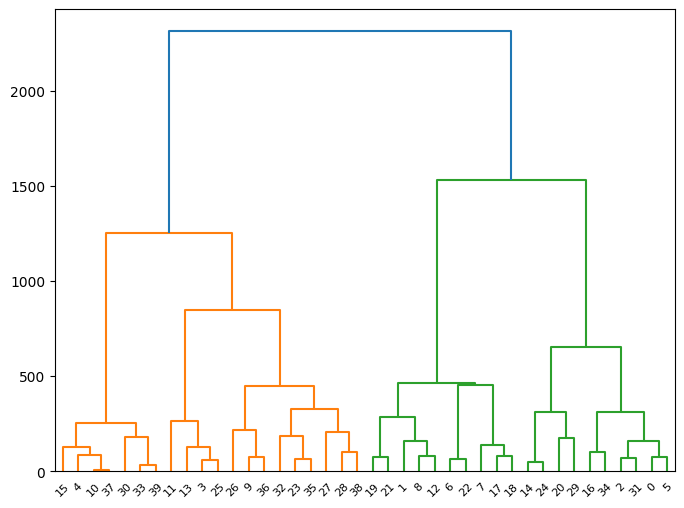

In [61]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
from collections import deque

linked = linkage(X, method='ward')

plt.figure(figsize=(8, 6))
dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=True)
plt.show()


In [62]:
from collections import Counter
queue = deque()

# Function to create clusters at each level of hierarchy
def get_clusters_at_level(linkage_matrix, num_clusters):
    """
    Get the clusters for a given number of clusters using fcluster.
    """
    return fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Iterate over each level of the hierarchy (from n_clusters = N to n_clusters = 1)
for level in range(2, X.shape[0] + 1):  # X.shape[0] + 1 for the number of points
    cluster_labels = get_clusters_at_level(linked, num_clusters=level)
    
    transformed_labels = np.zeros_like(cluster_labels)

    # Step 4: Get the unique cluster labels
    unique_clusters = np.unique(cluster_labels)

    # Step 5: For each unique cluster, check the majority true label and assign it
    for cluster in unique_clusters:
        # Get the indices of data points in this cluster
        indices_in_cluster = np.where(cluster_labels == cluster)[0]
        
        # Get the true labels for those data points
        true_labels_in_cluster = Y[indices_in_cluster]
        
        # Find the majority label in this cluster
        majority_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        
        # Assign the majority label to all points in this cluster
        transformed_labels[indices_in_cluster] = majority_label

    mismatch_indices = np.where(transformed_labels != Y)[0]
    if len(mismatch_indices) < 2:
        break
    queue.append(mismatch_indices)



# Step 1: Create an empty deque to store unique arrays
unique_queue = deque()

# Step 2: Iterate through the input queue and append only unique arrays to the new deque
for arr in queue:
    if not any(np.array_equal(arr, unique_arr) for unique_arr in unique_queue):
        unique_queue.append(arr)


# Step 5: Access and print clusters at each level from the queue
#while unique_queue:
#    clusters = unique_queue.pop()
#    print(f"Clusters at this level: {clusters}")

In [63]:
unique_queue

deque([array([14, 17]), array([17, 24]), array([18, 24])])

In [64]:
from pennylane import numpy as np
opt = qml.GradientDescentOptimizer(0.5)
circuit_executions = 0
params = random_params(num_wires=5, num_layers=6)

f_kernel = lambda x1, x2: kernel(x1, x2, params)
get_kernel_matrix = lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, f_kernel)
linked = linkage(get_kernel_matrix(X, X), method='average')
queue = deque()
for level in range(2, X.shape[0] + 1):  # X.shape[0] + 1 for the number of points
    cluster_labels = get_clusters_at_level(linked, num_clusters=level)
            
    transformed_labels = np.zeros_like(cluster_labels)

            # Step 4: Get the unique cluster labels
    unique_clusters = np.unique(cluster_labels)

            # Step 5: For each unique cluster, check the majority true label and assign it
    for cluster in unique_clusters:
                # Get the indices of data points in this cluster
        indices_in_cluster = np.where(cluster_labels == cluster)[0]
                
                # Get the true labels for those data points
        true_labels_in_cluster = Y[indices_in_cluster]
                
                # Find the majority label in this cluster
        majority_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
                
                # Assign the majority label to all points in this cluster
        transformed_labels[indices_in_cluster] = majority_label

    mismatch_indices = np.where(transformed_labels != Y)[0]
    if len(mismatch_indices) < 2:
        break
    queue.append(mismatch_indices)
unique_queue = deque()

        # Step 2: Iterate through the input queue and append only unique arrays to the new deque
for arr in queue:
    if not any(np.array_equal(arr, unique_arr) for unique_arr in unique_queue):
        unique_queue.append(arr)


for i in range(10):
    while unique_queue:
        datapoints = unique_queue.pop()
        print(datapoints)
        cost = lambda _params: -qml.kernels.target_alignment(
            X[datapoints],
            Y[datapoints],
            lambda x1, x2: kernel(x1, x2, _params),
            assume_normalized_kernel=True,
        )
        # Optimization step
        params = opt.step(cost, params)


    f_kernel = lambda x1, x2: kernel(x1, x2, params)
    get_kernel_matrix = lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, f_kernel)
    linked = linkage(get_kernel_matrix(X, X), method='average')
    queue = deque()
    for level in range(2, X.shape[0] + 1):  # X.shape[0] + 1 for the number of points
        cluster_labels = get_clusters_at_level(linked, num_clusters=level)
            
        transformed_labels = np.zeros_like(cluster_labels)

            # Step 4: Get the unique cluster labels
        unique_clusters = np.unique(cluster_labels)

            # Step 5: For each unique cluster, check the majority true label and assign it
        for cluster in unique_clusters:
                # Get the indices of data points in this cluster
            indices_in_cluster = np.where(cluster_labels == cluster)[0]
                
                # Get the true labels for those data points
            true_labels_in_cluster = Y[indices_in_cluster]
                
                # Find the majority label in this cluster
            majority_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
                
                # Assign the majority label to all points in this cluster
            transformed_labels[indices_in_cluster] = majority_label

        mismatch_indices = np.where(transformed_labels != Y)[0]
        if len(mismatch_indices) < 2:
            break
        queue.append(mismatch_indices)
    unique_queue = deque()

        # Step 2: Iterate through the input queue and append only unique arrays to the new deque
    for arr in queue:
        if not any(np.array_equal(arr, unique_arr) for unique_arr in unique_queue):
            unique_queue.append(arr)
        
    current_alignment = qml.kernels.target_alignment(
                X,
                Y,
                lambda x1, x2: kernel(x1, x2, params),
                assume_normalized_kernel=True,
            )
    print(f"Alignment = {current_alignment:.3f}")
    print(f"Circuit Executions: {circuit_executions}")

[ 8 22]
[ 8 22 38]
[ 8 22 23 38]
[ 8 21 22 23 38]
[ 8 19 21 22 23 38]
[ 8 19 21 22 23 24 38]
[ 8 19 21 22 23 24 32 38]
[ 8 15 21 22 23 24 32 38]
[ 8 15 21 22 23 24 32 33 38]
[ 8 15 16 21 22 23 24 32 33]
[ 8 10 15 16 21 22 23 32 33 37]
[ 8 10 15 21 22 23 32 33 36 37 38]
[ 5  8 10 15 21 22 23 32 36 37 38]
[ 1  5  8 15 21 22 23 24 32 36 38]
[ 4  5  8 10 15 21 22 23 27 32 36 37 38]
[ 1  5  6  8 15 20 21 22 23 24 32 36 38]
[ 4  8  9 10 13 15 22 23 27 32 33 36 37 38]
[ 2  4  8  9 10 13 15 22 23 27 33 34 36 37 38]
[ 2  3  4  8  9 10 13 15 23 27 33 34 36 37 38]
[ 3  4  8  9 10 13 15 23 26 27 32 33 35 36 37 38 39]
[ 3  4  9 10 11 13 15 23 26 27 28 32 33 35 36 37 38 39]
Alignment = 0.121
Circuit Executions: 5120
[11 22]
[ 8 22]
[ 8 22 38]
[ 8 22 23 38]
[ 8 21 22 23 38]
[ 8 19 21 22 23 38]
[ 8 19 21 22 23 24 38]
[ 8 19 21 22 23 24 32 38]
[ 8 15 21 22 23 24 32 38]
[ 8 15 16 21 22 23 24 32]
[ 8 10 15 16 21 22 23 32 37]
[ 8 10 15 16 21 22 23 32 33 37]
[ 1  8 15 16 21 22 23 24 32 33]
[ 1  5  8 15 16 

KeyboardInterrupt: 

In [29]:

params = random_params(num_wires=5, num_layers=6)
opt = qml.GradientDescentOptimizer(0.2)
circuit_executions = 0
for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -qml.kernels.target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = qml.kernels.target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")
        print(f"Circuit Executions: {circuit_executions}")

Step 50 - Alignment = 0.132
Circuit Executions: 1080
Step 100 - Alignment = 0.135
Circuit Executions: 2160
Step 150 - Alignment = 0.139
Circuit Executions: 3240
Step 200 - Alignment = 0.143
Circuit Executions: 4320
Step 250 - Alignment = 0.146
Circuit Executions: 5400
Step 300 - Alignment = 0.148
Circuit Executions: 6480
Step 350 - Alignment = 0.150
Circuit Executions: 7560
Step 400 - Alignment = 0.153
Circuit Executions: 8640
Step 450 - Alignment = 0.155
Circuit Executions: 9720
Step 500 - Alignment = 0.156
Circuit Executions: 10800


In [68]:
from pennylane import numpy as np
from sklearn.cluster import SpectralClustering, KMeans
opt = qml.GradientDescentOptimizer(0.5)
circuit_executions = 0
params = random_params(num_wires=5, num_layers=6)

f_kernel = lambda x1, x2: kernel(x1, x2, params)
get_kernel_matrix = lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, f_kernel)

In [67]:
class_1_indices = np.where(Y == 1)[0]
class_2_indices = np.where(Y == -1)[0]

class1 = X[class_1_indices]
class2 = X[class_2_indices]

class1_kernel_matrix = get_kernel_matrix(class1, class1)
class2_kernel_matrix = get_kernel_matrix(class2, class2)

In [70]:
main_cluster = KMeans(n_clusters=1, random_state=42)
cluster = KMeans(n_clusters=4, random_state=42)

class1_cent_cluster = main_cluster.fit_predict(class1_kernel_matrix)
centroid1 = main_cluster.cluster_centers_
centroid1 = centroid1[:, :len(X[0])]

class2_cent_cluster = main_cluster.fit_predict(class2_kernel_matrix)
centroid2 = main_cluster.cluster_centers_
centroid2 = centroid1[:, :len(X[0])]


class1_clusters = cluster.fit_predict(class1_kernel_matrix)
class1_centroids = cluster.cluster_centers_
class1_centroids = class1_centroids[:, :len(X[0])]


class2_clusters = cluster.fit_predict(class2_kernel_matrix)
class2_centroids = cluster.cluster_centers_
class2_centroids = class2_centroids[:, :len(X[0])]

In [ ]:
data_queue = deque()

for i in class1_centroids:
    data_queue.append()